Let's go through the process of modeling a first-order plus dead time (FOPDT) system, which can represent the charging of a capacitor in an RC circuit. We'll start with the ordinary differential equation (ODE), find its analytical solution, convert it to the Laplace domain, and then derive a difference equation suitable for implementation on a microcontroller.




In [133]:
import control as ctrl
import matplotlib.pyplot as plt
import numpy as np


### Step 1: Ordinary Differential Equation (ODE)

The charging of a capacitor in an RC circuit can be described by the following first-order ODE:

$RC \frac{dV_c(t)}{dt} + V_c(t) = V_{in}(t)$

where:
- $V_c(t)$ is the voltage across the capacitor as a function of time.
- $V_{in}(t)$ is the input voltage.
- $R$ is the resistance.
- $C$ is the capacitance.
- $RC$ is the time constant $\tau$of the system.

In [134]:
R = 1e3  # Resistance in ohms
C = 1e-6  # Capacitance in farads
tau = R * C  # Time constant
T = 0.01  # Sampling time in seconds

## Step 2: Analytical Solution

The analytical solution to this ODE for a step input $V_{in}(t) = V_0 \cdot u(t) $, where $u(t)$is the unit step function, is given by:

$V_c(t) = V_0 \left(1 - e^{-t/RC}\right)$

This solution shows how the capacitor voltage charges exponentially towards the input voltage $V_0 $.

After one time constant $(t=τt=τ)$, the capacitor will have charged to approximately 63.2% of the applied voltage $V_0$​. This percentage comes from evaluating the exponential function at $t=τt=τ$:  
$V_c(τ)=V_0(1−e−1)≈V_0(1−0.3679)≈0.632×V_0$
$V_c​(τ)=V_0​(1−e−1)≈V_0​(1−0.3679)≈0.632×V_0​$

So, after one time constant, the capacitor is about 63.2% charged. Similarly, after two time constants, the capacitor will be about 86.5% charged, after three time constants about 95%, and after five time constants, it is considered almost fully charged (about 99.2%).

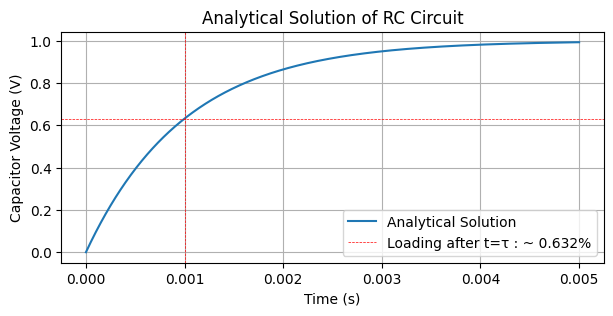

In [135]:
# Time array for analytical solution
t = np.linspace(0, 5*tau, 1000)
V0 = 1  # Step input magnitude

# Analytical solution
Vc_analytical = V0 * (1 - np.exp(-t/tau))

# Plot the analytical solution
plt.figure(figsize=(7, 3))
plt.plot(t, Vc_analytical, label='Analytical Solution')
plt.title('Analytical Solution of RC Circuit')
plt.xlabel('Time (s)')
plt.ylabel('Capacitor Voltage (V)')
plt.grid()
ax = plt.gca()
ax.axhline(y=1-np.exp(-1), color='red', lw=0.5, ls='--')
ax.axvline(x=tau, color='red', lw=0.5, ls='--', label=f'Loading after t=τ : ~ {(1-np.exp(-1)):.3f}%')
plt.legend()
#plt.hlines(y=[1-np.exp(-1)], color='black', lw=0.5)

## Step 3: Laplace Domain Representation

To convert the ODE to the Laplace domain, we take the Laplace transform of both sides. The Laplace transform of the ODE is:

$RC \left(sV_c(s) - V_c(0)\right) + V_c(s) = V_{in}(s)$

Assuming the initial condition $V_c(0) = 0 $, this simplifies to:

$RCsV_c(s) + V_c(s) = V_{in}(s)$

Factoring out $V_c(s) $, we get:

$V_c(s) (RCs + 1) = V_{in}(s)$

Thus, the transfer function $G(s)$in the Laplace domain is:

$G(s) = \frac{V_c(s)}{V_{in}(s)} = \frac{1}{RCs + 1}$

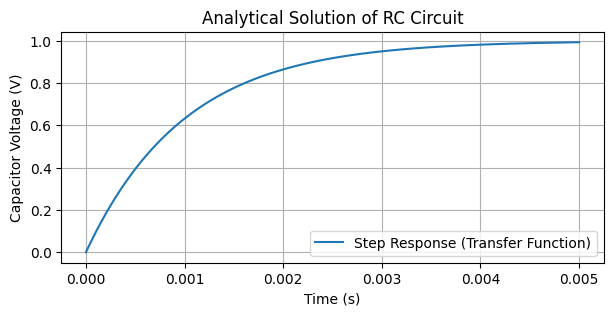

In [136]:
# Define the transfer function in Laplace domain
s = ctrl.TransferFunction.s
G_s = ctrl.TransferFunction(1 / (tau * s + 1))  # Create transfer function object
R_laplace = ctrl.step_response(G_s,t)

plt.figure(figsize=(7, 3))
plt.plot(R_laplace.time, R_laplace.y.flatten(), label='Step Response (Transfer Function)')
plt.title('Analytical Solution of RC Circuit')
plt.xlabel('Time (s)')
plt.ylabel('Capacitor Voltage (V)')
plt.grid()
plt.legend()


## Step 5: Discretization for Microcontroller Implementation

To implement this on a microcontroller, we need to discretize the continuous-time transfer function. We'll use the backward Euler method for discretization. The continuous-time transfer function without dead time is:

$G(s) = \frac{1}{RCs + 1}$

Using the substitution $s \approx \frac{1 - z^{-1}}{T} $, where $T$is the sampling time, we get:

$G(z) = \frac{1}{RC \frac{1 - z^{-1}}{T} + 1} = \frac{T}{RC + T - RCz^{-1}}$

Rearranging, we obtain:

$G(z) = \frac{\frac{T}{RC + T}}{1 - \frac{RC}{RC + T} z^{-1}}$

This can be written as:

$G(z) = \frac{b}{1 - a z^{-1}}$

where $a = \frac{RC}{RC + T}$ and $b = \frac{T}{RC + T} $

Discrete-Time Transfer Function G(z):


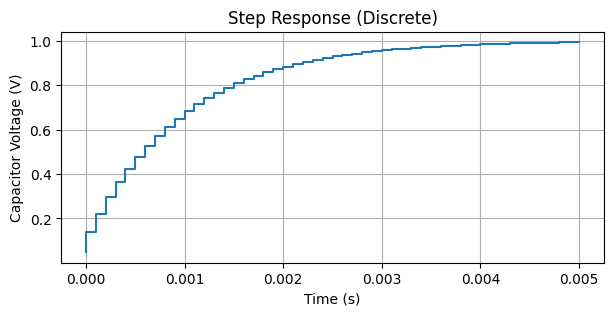

In [137]:
# Discretize the transfer function
Ts=0.0001 # sample time
G_z = ctrl.c2d(G_s, Ts, method='bilinear')

# Print the discrete-time transfer function
print("Discrete-Time Transfer Function G(z):")
G_z

#simulate and draw
R_z = ctrl.step_response(G_z, T=0.005)
plt.figure(figsize=(7, 3))
plt.step(R_z.time, R_z.y.flatten())
plt.title('Step Response (Discrete)')
plt.xlabel('Time (s)')
plt.ylabel('Capacitor Voltage (V)')
plt.grid()

## Step 6: Difference Equation

The difference equation corresponding to this discrete-time transfer function is:

$V_c[k] = a V_c[k-1] + b V_{in}[k]$

This difference equation can be implemented on a microcontroller to update the capacitor voltage $V_c$ at each time step $k$ . The dead time $\theta$ can be handled by introducing a delay in the implementation, such as using a buffer to store past input values.

By following these steps, you can model the charging of a capacitor, convert it to a discrete-time system, and implement it on a microcontroller.

Rearranging, we obtain:

$G(z) = \frac{\frac{T}{RC + T}}{1 - \frac{RC}{RC + T} z^{-1}}$

This can be written as:  
$G(z) = \frac{b}{1 - a z^{-1}}$,  $a = \frac{RC}{RC + T}$ and $b = \frac{T}{RC + T} $  
$\Leftrightarrow V_c[k] (1-a \cdot z^{-1}) = V_i[k]\cdot b$  
$\Leftrightarrow  V_c[k] = V_c[k-1]\cdot a + V_{i}[k] \cdot b$

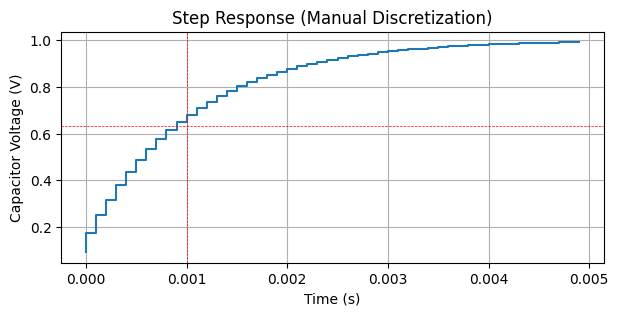

In [143]:
a = tau/(tau+Ts)
b = Ts/(tau+Ts)

V0 = 1
num_steps = int(0.005 / Ts)  # Number of steps for simulation
Vin = np.ones(num_steps) * V0
Vc = np.zeros(num_steps)
for k in np.arange(0, num_steps):
    Vc[k] = a * Vc[k-1] + b * Vin[k]
R_manual = {'time': Ts * np.arange(0, num_steps), 'y': Vc}

plt.figure(figsize=(7, 3))
plt.step(R_manual['time'], R_manual['y'], label='Step Response (Manual Discretization)')
plt.title('Step Response (Manual Discretization)')
plt.xlabel('Time (s)')
plt.ylabel('Capacitor Voltage (V)')
plt.grid()
ax = plt.gca()

ax.axvline(x=tau, color='red', lw=0.5, ls='--', label=f'Loading after t=τ : ~ {(1-np.exp(-1)):.3f}%')
ax.axhline(y=1-np.exp(-1), color='red', lw=0.5, ls='--')
